# Practical Class 6 - Modelling of Resistive DACs at element level

In [109]:
from functools import partial

# mathematical computing
import numpy as np
import scipy as sp
from scipy import signal # to generate the noise signal
import seaborn as sns # to observe the noise signal's histogram

sns.set_theme()
sns.set_palette("colorblind")

from numpy.random import uniform, normal # random numbers fitted into a uniform distribution
# plotting
import matplotlib.pyplot as plt
# import the models and utilities functions
from utils import ideal_dac, ideal_adc, nonideal_adc, dec2bin, bin2dec

%matplotlib inline

## Modelling of a Thermometer Code DAC


<p align="center">
    <img src="../docs/imgs/thermometer_dac.png" alt="thermometer-dac" width="300">
</p>

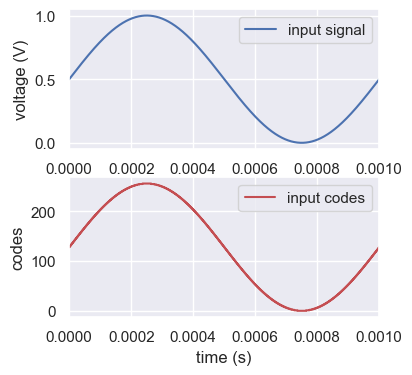

In [110]:
# set up the DAC parameters
vref = 1 # V
nbits = 8 # number of bits
vlsb = vref / (2**nbits) # V
# number of simulation points
Np = 1e6
# define the time base
Fs = 1e9 # Hz
Ts = 1/Fs # s
tD = np.arange(0,Np)*Ts; # (0:Np-1) == np.arange(0,Np)
# setup the input codes
A1 = vref/2
f1 = 1e3 # Hz
ph1 = 0 # rad
ofst = 0.0
si = A1*np.sin(2*np.pi*f1*tD + ph1) + ofst + vref/2
# get the codes from the ideal DAC
incodes = np.round(si/vlsb).astype(int)
# represent the input signal and codes
fig, ax = plt.subplots(2,1, figsize=(4,4))
ax[0].plot(tD, si, 'b', label='input signal')
ax[0].set_xlabel('time (s)')
ax[0].set_ylabel('voltage (V)')
ax[0].legend()
ax[1].plot(tD, incodes, 'r', label='input codes')
ax[1].set_xlabel('time (s)')
ax[1].set_ylabel('codes')
ax[1].legend()
ax[0].set_xlim([0, 1/(f1)])
ax[1].set_xlim([0, 1/(f1)])
ax[1].grid(True); ax[0].grid(True)

Text(0.5, 1.0, 'resistor values distribution')

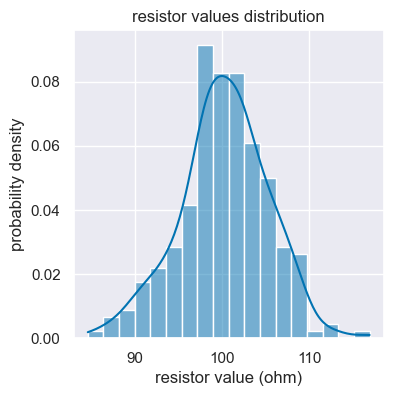

In [111]:
# model the resistor ladder
ru = 100 # ohm - unit resistance
R = np.ones(2**nbits)*ru
# resistance mismatch in ohm, following a normal distribution
u_err = 0.0
u_std = 0.05 # 5% of the unit resistance for a semiconductor resistor
r_err = normal(u_err, u_std, 2**nbits)
R = R + r_err*ru
# show the resistor values
fig, ax = plt.subplots(1,1, figsize=(4,4))
sns.histplot(R, ax=ax, stat="density", kde=True)
ax.set_xlabel('resistor value (ohm)')
ax.set_ylabel('probability density')
ax.grid(True)
ax.set_title('resistor values distribution')

Text(0.5, 1.0, 'DAC transfer function')

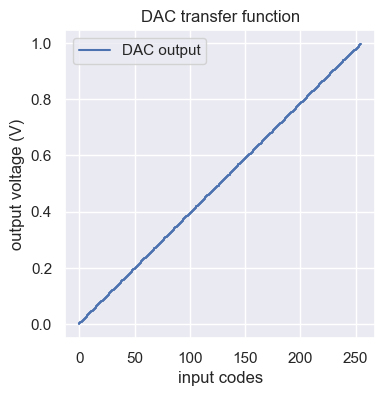

In [112]:
# compute the DAC output voltage for each input code, considering the errors in the resistors
codes = np.arange(2**nbits)
vout_nonideal = np.array([np.sum(R[:code])/np.sum(R) for code in codes])
# observe the DAC transfer function
fig, ax = plt.subplots(1,1, figsize=(4,4))
ax.step(codes,vout_nonideal, 'b', label='DAC output')
ax.set_xlabel('input codes')
ax.set_ylabel('output voltage (V)')
ax.legend()
ax.grid(True)
ax.set_title('DAC transfer function')

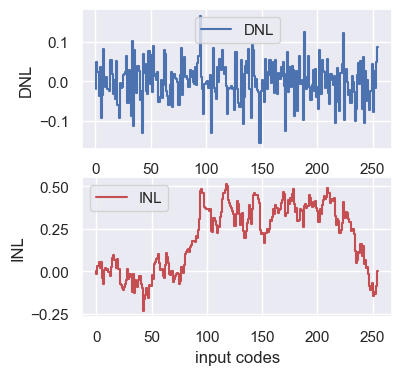

In [113]:
# compute the DNL and INL of the DAC featuring the resistor mismatch
vlsb_measured = (vout_nonideal[2**nbits - 1] - vout_nonideal[0])/(2**nbits - 1)
dnl = np.diff(vout_nonideal)/vlsb_measured - 1
inl = np.array([0] + np.cumsum(dnl).tolist())
assert len(dnl) == 2**nbits - 1
assert len(inl) == 2**nbits
# plot the DNL and INL
fig, ax = plt.subplots(2,1, figsize=(4,4))
ax[0].step(codes[1:], dnl, 'b', label='DNL')
ax[0].set_xlabel('input codes')
ax[0].set_ylabel('DNL')
ax[0].legend()
ax[0].grid(True)
ax[1].step(codes, inl, 'r', label='INL')
ax[1].set_xlabel('input codes')
ax[1].set_ylabel('INL')
ax[1].legend()
ax[1].grid(True)

As it is possible to observe, the DAC is sensitive to resistor mismatch, severely impacting its INL, which translates in vlasb errors when producing the output voltage. Let us now compute the effective resolution of 100 thermometer ladder DAC converters for a random resistor mismatch following a normal distribution, and check the histogram of the effective resolution of the DACs. This is a very common analysis to check the impact of device mismatch on the performance of a converter circuit.

Text(0.5, 1.0, 'DAC resolution distribution against resistor mismatch')

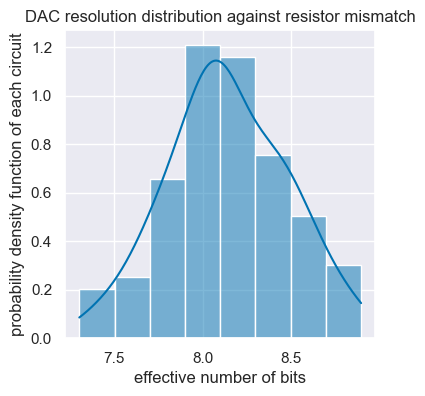

In [114]:
# generate several ladder circuits, with random resistance wheights every time, and observe the histogram of 
# the resolution of the DAC
ncircuits = 100
dac_res = [] # measure the effective resolution for each of the circuits
# resistance mismatch in ohm, following a normal distribution
u_err = 0.0
u_std = 0.05 # 5% of the unit resistance for a semiconductor resistor
for circ in range(ncircuits):
    R = np.ones(2**nbits)*ru
    r_err = normal(u_err, u_std, 2**nbits)
    R = R + r_err*ru
    codes = np.arange(2**nbits)
    vout_nonideal = np.array([np.sum(R[:code])/np.sum(R) for code in codes])
    vlsb_measured = (vout_nonideal[2**nbits - 1] - vout_nonideal[0])/(2**nbits - 1)
    dnl = np.diff(vout_nonideal)/vlsb_measured - 1
    inl = np.array([0] + np.cumsum(dnl).tolist())
    # compute the effective number of bits of the DAC using the INL (once the lost bits can be compute by the 
    # difference between the minimum and maximum value of the INL)
    dac_linearity = nbits - np.log2(np.max(inl) - np.min(inl))
    dac_res.append(dac_linearity)
# plot the histogram of the effective number of bits of the DAC
fig, ax = plt.subplots(1,1, figsize=(4,4))
sns.histplot(dac_res, ax=ax, stat="density", kde=True)
ax.set_xlabel('effective number of bits')
ax.set_ylabel('probability density function of each circuit')
ax.grid(True)
ax.set_title('DAC resolution distribution against resistor mismatch')

Let us now consider the dynamic operation of the DAC. Let us assume that at the DAC's output voltage is charging a parasitic capacitor of 0.1 pF, and the DAC is clocked at 1 MHz. Naturally, due to the output node pole defined by its RC time constant, the output voltage will not change instantaneously, but will follow a step response. Three main questions arise:
- 1 - How long does it take to charge the output capacitance to 95% of the final value of the output voltage?
- 2 - What impact does the unitary resistances of the DAC have on the output voltage step response?
- 3 - What impact do the switches have on the output voltage step response?
- 
Let us answer those questions in this section.

The settling error can be computed through:
$$
\begin{align}
\epsilon_{S} &= \frac{V^*_{out} - V_{out}}{V_{out}} = e^{-\frac{T_{CLK}}{\tau}} \\
\end{align}
$$

where $V_{out} = V_{REF}\frac{R2}{R2 + R1}$ is the ideal output voltage at the end of the half-clock period, and $V^*_{out}(t) = V_{REF}\frac{R2}{R2 + R1}(1-e^{-\frac{t}{\tau}})$ is the actual observed final output voltage. The RC time constant of the output node is given by:
$$
\begin{align}
\tau &= (C_L + C_P)*( R1 // R2 + R_{SW}) \hspace{4pt} \text{(s)}
\end{align}
$$

where $C_L$ is the load capacitance, $C_P$ is the node parasitic capacitance, $R1$ and $R2$ are the top and bottom equivalent resistances of the DAC ladder, and $R_{SW}$ is the switch ON resistance.

/var/folders/vv/xctyh4bd2td6k2w_gvh_t2vr0000gn/T/ipykernel_50265/1943781312.py:31: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(tD/1e-9)


(0.0, 1e-08)

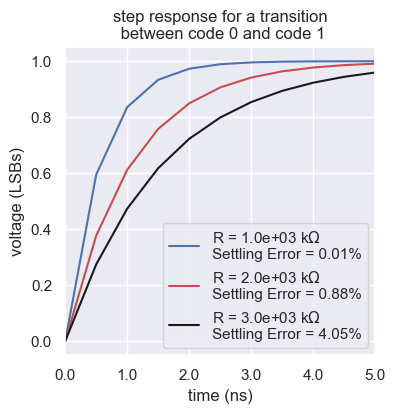

In [115]:
# plot the ideal step response
vo = lambda t_, vr_, r1_, r2_, tau_: vr_*r2_/(r1_+r2_)*(1 - np.exp((-t_/tau_)))
# compute the step respose for a transition between code 0 and code 1
fig, ax = plt.subplots(1,1, figsize=(4,4))
CL = 1e-12 # F - load capacitance
ru = 1e3 # ohm - unit resistance
num_rus = 3
rus = np.arange(1, num_rus+1)*ru
r_sw = 100 # ohm - switch resistance
cp_sw = 0.01*CL # F - switch capacitance
fclk = 100e6 # 100 MHz - clock frequency
colors = ['b', 'r', 'k', 'c', 'm', 'y', 'g']
for ru, color in zip(rus, colors):
    R = np.ones(2**nbits)*ru
    assert len(R) == 2**nbits
    req1 = sum(R[:-1]) # equivalent resistance of the top of the ladder for code 0
    req2 = R[-1] # equivalent resistance of the bottom of the ladder for code 1
    tclk = 1/fclk # s - clock period -> maximum settling time
    tauu = (CL + cp_sw)*((req1*req2)/(req1+req2) + r_sw) # tau ~= (CL + Cp)*( R1//R2 + Rsw )
    vout_t = vo(tD, vref, req1, req2, tauu)
    # compute stelling error
    err_set = np.exp(-tclk/tauu) # err _settling = [(vout - vout_ideal)/vout_ideal] = e^(-tclk/tau)
    err_set_pct = err_set*100
    #print('tau = {:.2e} s'.format(tauu))
    #print("tclk = {:.2e} s".format(tclk))
    #print("tclk/tau = {:.2f}".format(tclk/tauu))
    #print("tclk/Ts = {:.2f}".format(tclk/Ts))
    ax.plot(tD, vout_t/vlsb, color, label='R = {:.1e} k'.format(ru)+r'$\Omega$'\
        + '\nSettling Error = {:.2f}%'.format(err_set_pct))
ax.set_xlabel('time (ns)')
ax.set_xticklabels(tD/1e-9)
ax.set_ylabel('voltage (LSBs)')
ax.grid(True)
ax.legend()
ax.set_title('step response for a transition\n between code 0 and code 1')
ax.set_xlim(0, tclk)

Text(0.5, 1.0, 'DAC Output RC Delay vs. Input Code Transistion')

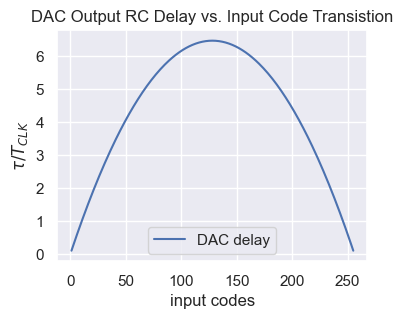

In [116]:
# observe the delay of the DAC agains the code transition
codes = np.arange(2**nbits)
ru = 1e3 # ohm - unit resistance
R = np.ones(2**nbits)*ru
tauu = np.array([
    (CL+cp_sw)*((np.sum(R[:code])*np.sum(R[code:]))/(np.sum(R[:code])+np.sum(R[code:])) + r_sw) for code in codes[1:]
])
fig, ax = plt.subplots(1,1, figsize=(4,3))
ax.plot(codes[1:], tauu/tclk, 'b', label='DAC delay')
ax.set_xlabel('input codes')
ax.set_ylabel(r'$\tau / T_{CLK}$')
ax.legend()
ax.grid(True)
ax.set_title('DAC Output RC Delay vs. Input Code Transistion')

In [117]:
# compute the static power dissipation of the DAC
ru = 1e3 # ohm - unit resistance
R = np.ones(2**nbits)*ru
PD = (vref**2)/(len(R)*ru) # W - static power dissipation of the DAC
print('PD = {:.2f} uW'.format(PD/1e-6))

PD = 3.91 uW


One conclusion that we can retrieve from the previous analysis is that in order to reduce the overall delay of the DAC, we should reduce the RC time constant of the output node by reducing the unitary resistance of the unit resistor of the ladder. However, the lower the unitary resistance, the higher will be the mismatch sensitivity of the DAC, as well as the total static dissipated power of the thermometer ladder DAC. 

This observation holds true in general, for all DAC and ADC architectures. The total dissipated power of converters will innevitably be higher when aiming for a converters that present a lower settling error and operate at faster conversion steps.

## Modelling of a Binary Weighted Resistor DAC

<p align="center">
    <img src="../docs/imgs/bin_weight_res_dac.png" alt="binary-weighted-resistor-dac" width="400">
</p>

<p align="justify">
NOTE: B0 is most significant bit of the DAC, associated with the lowest resistor value in the resistor array,
and subsequnetly to the highest voltage output change when the bit is toggled.
</p>

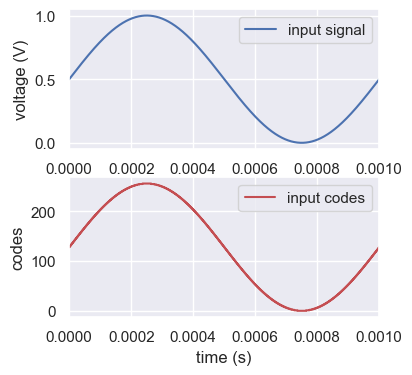

In [118]:
# set up the DAC parameters
vref = -1 # V
vdd = 1 # V
nbits = 8 # number of bits
vlsb = np.abs(vref / (2**nbits) ) # V
# number of simulation points
Np = 1e6
# define the time base
Fs = 1e9 # Hz
Ts = 1/Fs # s
tD = np.arange(0,Np)*Ts; # (0:Np-1) == np.arange(0,Np)
# setup the input codes
A1 = vdd/2
f1 = 1e3 # Hz
ph1 = 0 # rad
ofst = 0.0
si = A1*np.sin(2*np.pi*f1*tD + ph1) + ofst + vdd/2
# get the codes from the ideal DAC
incodes = np.round(si/vlsb).astype(int)
# represent the input signal and codes
fig, ax = plt.subplots(2,1, figsize=(4,4))
ax[0].plot(tD, si, 'b', label='input signal')
ax[0].set_xlabel('time (s)')
ax[0].set_ylabel('voltage (V)')
ax[0].legend()
ax[1].plot(tD, incodes, 'r', label='input codes')
ax[1].set_xlabel('time (s)')
ax[1].set_ylabel('codes')
ax[1].legend()
ax[0].set_xlim([0, 1/(f1)])
ax[1].set_xlim([0, 1/(f1)])
ax[1].grid(True); ax[0].grid(True)

Text(0.5, 1.0, 'resistor values distribution')

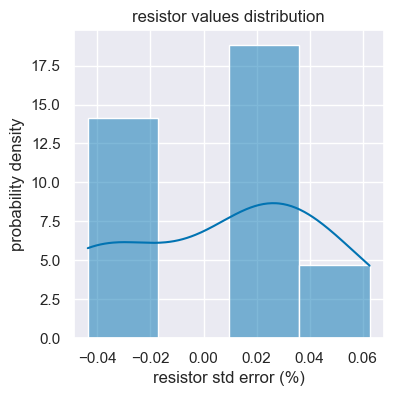

In [119]:
# model the binary wheighted resistors
ru = 100 # ohm - unit resistance
# create the binary weighted resistors 
R_ideal = np.array([ru*(2**i) for i in range(nbits)])
# resistance mismatch in ohm, following a normal distribution
u_err = 0.0
u_std = 0.05 # 5% of the unit resistance for a semiconductor resistor
r_err = normal(u_err, u_std, nbits)
R = np.array([r + r_err[i]*r for i, r in enumerate(R_ideal)])
# feedback resistor 
rf = ru/2

fig, ax = plt.subplots(1,1, figsize=(4,4))
sns.histplot(r_err, ax=ax, stat="density", kde=True)
ax.set_xlabel('resistor std error (%)')
ax.set_ylabel('probability density')
ax.grid(True)
ax.set_title('resistor values distribution')

codes :  [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 1]
 [0 0 0 ... 0 1 0]
 ...
 [1 1 1 ... 1 0 1]
 [1 1 1 ... 1 1 0]
 [1 1 1 ... 1 1 1]]
resistors :  [   96.95293716   204.16380464   410.09007877   820.82509968
  1645.57089828  3066.86552893  6120.78683988 13601.05487024]
[13601.05487024]


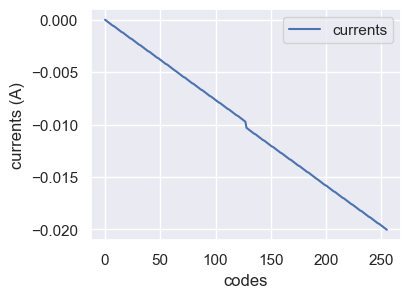

In [120]:
# convert the codes from decimal to binary,
# and get the indexes of the resistor 
# conducting the current
codes = np.arange(2**nbits)
incodes_bin = dec2bin(codes, nbits)
print("codes : ", incodes_bin)
print("resistors : ", R)

"""NOTE:
The Most Significant Bit (MSB) is associated with the smallest resistor
of the array in the DAC ( the unit resistor Ru ). This makes sense for 
a very simple reason: the MSB is associated with the highest voltage change in the 
DAC, and consequently it has to be associated with the highest change in the current 
flowing through the feedback resistor - which is true, once the lowest resistor of the DAC array
will be the one generating the highest current.
"""

# get transconductances 
G = np.array([1/r for r in R])
# for each code, compute the output voltage
print(R[incodes_bin[1] == 1])
currents = np.array([
    vref*np.sum(G[icodes == 1]) for icodes in incodes_bin
])
# plot currents vs. codes
fig, ax = plt.subplots(1,1, figsize=(4,3))
ax.plot(codes, currents, 'b', label='currents')
ax.set_xlabel('codes')
ax.set_ylabel('currents (A)')
ax.grid(True)
ax.legend()

vout_nonideal = -currents*rf

Text(0.5, 1.0, 'Binary Weighted Resistor DAC Transfer Function')

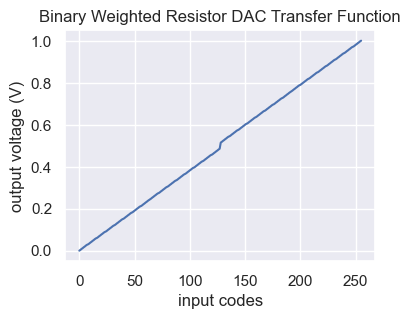

In [121]:
# plot the trasnfer function of the DAC
fig, ax = plt.subplots(1,1, figsize=(4,3))
ax.plot(codes, vout_nonideal, 'b', label='DAC transfer function')
ax.set_xlabel('input codes')
ax.set_ylabel('output voltage (V)')
ax.grid(True)
ax.set_title('Binary Weighted Resistor DAC Transfer Function')

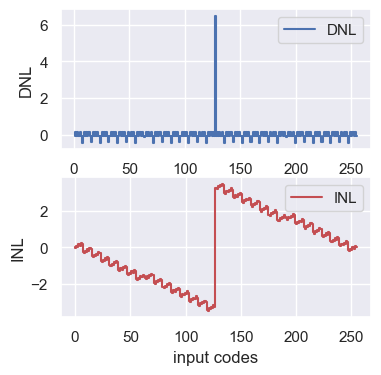

In [122]:
# compute the DNL and INL of the DAC featuring the resistor mismatch
vlsb_measured = (vout_nonideal[2**nbits - 1] - vout_nonideal[0])/(2**nbits - 1)
dnl = np.diff(vout_nonideal)/vlsb_measured - 1
inl = np.array([0] + np.cumsum(dnl).tolist())
assert len(dnl) == 2**nbits - 1
assert len(inl) == 2**nbits
# plot the DNL and INL
fig, ax = plt.subplots(2,1, figsize=(4,4))
ax[0].step(codes[1:], dnl, 'b', label='DNL')
ax[0].set_xlabel('input codes')
ax[0].set_ylabel('DNL')
ax[0].legend()
ax[0].grid(True)
ax[1].step(codes, inl, 'r', label='INL')
ax[1].set_xlabel('input codes')
ax[1].set_ylabel('INL')
ax[1].legend()
ax[1].grid(True)

Text(0.5, 1.0, 'DAC resolution distribution against resistor mismatch')

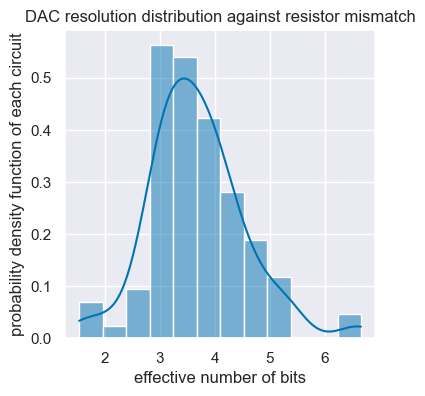

In [123]:
# generate several binary weighted resistor
# circuits, with random resistance wheights 
# every time, and observe the histogram of 
# the resolution of the DAC
ncircuits = 100
dac_res = [] # measure the effective resolution for each of the circuits
# resistance mismatch in ohm, following a normal distribution
u_err = 0.0
u_std = 0.05 # 15% of the unit resistance for a semiconductor resistor
codes = np.arange(2**nbits)
# get the binary codes
incodes_bin = dec2bin(codes, nbits)
for circ in range(ncircuits):
    R_ideal = np.array([ru*(2**i) for i in range(-1, nbits)])
    # feedback resistor
    rf = R_ideal[0]
    # resistor array
    R_ideal = R_ideal[1:]
    # resistance mismatch in ohm, following a normal distribution
    u_err = 0.0
    u_std = 0.15 # 15% of the unit resistance for a semiconductor resistor
    r_err = normal(u_err, u_std, nbits)
    R = R_ideal + np.multiply(R_ideal, r_err)
    # get the transconductances
    G = np.array([1/r for r in R])
    # get the currents
    currents = np.array([
        vref*np.sum(G[icodes == 1]) for icodes in incodes_bin])
    vout_nonideal = -currents*rf
    vlsb_measured = (vout_nonideal[2**nbits - 1] - vout_nonideal[0])/(2**nbits - 1)
    dnl = np.diff(vout_nonideal)/vlsb_measured - 1
    inl = np.array([0] + np.cumsum(dnl).tolist())
    # compute the effective number of bits of the DAC using the INL (once the lost bits can be compute by the 
    # difference between the minimum and maximum value of the INL)
    dac_linearity = nbits - np.log2(np.max(inl) - np.min(inl))
    dac_res.append(dac_linearity)
# plot the histogram of the effective number of bits of the DAC
fig, ax = plt.subplots(1,1, figsize=(4,4))
sns.histplot(dac_res, ax=ax, stat="density", kde=True)
ax.set_xlabel('effective number of bits')
ax.set_ylabel('probability density function of each circuit')
ax.grid(True)
ax.set_title('DAC resolution distribution against resistor mismatch')

<p align="justify">
As it is possible to observe, the binary weighted resistor DAC is much more sensitive to resistor mismatch than the thermometer ladder DAC. This is due to the fact the higher is the resistor's resistance, the higher will be the deviation (in iohms) from the ideal value, although it is the same in terms of percentage. As such, transistions associated with input codes featuring changes in the least significant bits will be more sensitive to resistor mismatch than transistions associated with input codes featuring changes only in the most significant bits. 
</p>

<h3 align="justify"> Reducing mismatch sensitivity of binary weighted resistor arrays </h3>

<p align="justify">
In practice, one way to reduce the mismatch sensitivity of the DAC is to correctly design the resistor array in the circuit's layout. Instead of using variable length polysilicon resistors, a single fixed length and width resistor is used for the highest resistor of the array, and the subsequent resistors are implemented as a parallel combination a a power-of-two number of this highest resistance resistor to make the smaller resistors of the array. Because the standard deviation of the mismatch value of the highest resistor is the same for all the resistors of the array, the mismatch sensitivity of the DAC is reduced once the effective mismatch of the smaller resistors (made by parallel combinations of the resistor with the highest mismatch) decreases.
</p>

Of course that the tradeoff is the in-silicon occupied area. In the classic configuration there are N resistors in the array for a DAC with N bits of resolution, whereas in the proposed configuration there are $2^{N} - 1$ resistors in the array for a DAC with N bits of resolution.

Text(0.5, 1.0, 'DAC resolution distribution against resistor mismatch')

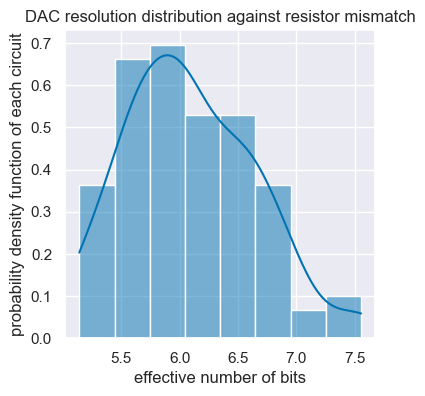

In [124]:
# generate several binary weighted resistor
# circuits, with random resistance wheights 
# every time, and observe the histogram of 
# the resolution of the DAC
ncircuits = 100
dac_res = [] # measure the effective resolution for each of the circuits
# resistance mismatch in ohm, following a normal distribution
ru = 2e3 # unit resistance in ohm
u_err = 0.0
u_std = 0.05 # 33% of the unit resistance for a semiconductor resistor
codes = np.arange(2**nbits)
# get the binary codes
incodes_bin = dec2bin(codes, nbits)
for circ in range(ncircuits):
    # generate the array of resistors made with parallel combinations of the unit resistor
    # NOTE that in this layout configuration, there are 2**nbits - 1 resistors in the array
    # whereas in the previous configuration there were nbits resistors
    R_ideal = np.ones(2**nbits-1)*ru
    R_idxs = {id: np.arange(2**id, 2**(id+1))-1 for id in range(nbits)}
    u_err = 0.0
    u_std = 0.15 # 15% of the unit resistance for a semiconductor resistor
    r_err = normal(u_err, u_std, len(R_ideal))
    R = R_ideal + np.multiply(R_ideal, r_err)
    # generate the binary weighted resistor array from 
    # the unit resistor in parallel combinations
    R = np.array([1/(np.sum([1/R[i] for i in R_idxs[id]])) for id in range(nbits)])
    R = R[::-1] # reverse the array to associate the MSB to lowest resistance resistor
    # feedback resistor
    rf = ru/2
    # get the transconductances
    G = np.array([1/r for r in R])
    # get the currents
    currents = np.array([
        vref*np.sum(G[icodes == 1]) for icodes in incodes_bin])
    vout_nonideal = -currents*rf
    vlsb_measured = (vout_nonideal[2**nbits - 1] - vout_nonideal[0])/(2**nbits - 1)
    dnl = np.diff(vout_nonideal)/vlsb_measured - 1
    inl = np.array([0] + np.cumsum(dnl).tolist())
    # compute the effective number of bits of the DAC using the INL (once the lost bits can be compute by the 
    # difference between the minimum and maximum value of the INL)
    dac_linearity = nbits - np.log2(np.max(inl) - np.min(inl))
    dac_res.append(dac_linearity)
# plot the histogram of the effective number of bits of the DAC
fig, ax = plt.subplots(1,1, figsize=(4,4))
sns.histplot(dac_res, ax=ax, stat="density", kde=True)
ax.set_xlabel('effective number of bits')
ax.set_ylabel('probability density function of each circuit')
ax.grid(True)
ax.set_title('DAC resolution distribution against resistor mismatch')

<p align="justify">
From the above histogram, is possible to observe that the implementation of the binary weighted resistor array 
designed through parallel combinations of the highest unitary resistor of the array enables the reduction of the mismatch sensitivity of the DAC, increasing the effective resolution of the DAC.
</p>

<h2 align="left"> Modelling a R-2R DAC </h2>

<p align="center">
<img src="../docs/imgs/r_2r_dac.png" width=500>
</p>

In [125]:
# set up the DAC parameters
vref = 1 # V
nbits = 8 # number of bits
vlsb = vref / (2**nbits) # V
# number of simulation points
Np = 1e6
# define the time base
Fs = 1e9 # Hz
Ts = 1/Fs # s
tD = np.arange(0,Np)*Ts; # (0:Np-1) == np.arange(0,Np)
# setup the input codes
A4 = vref/2
f4 = 1e3 # Hz
ph4 = 0 # rad
ofst = 0.0
si = A4*np.sin(2*np.pi*f4*tD + ph4) + ofst + vref/2
# get the codes from the ideal DAC
incodes = np.round(si/vlsb).astype(int)
# represent the input signal and codes

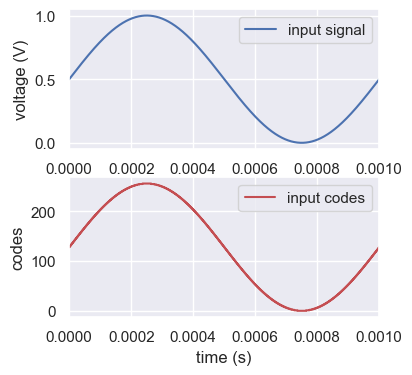

In [126]:
fig, ax = plt.subplots(2,1, figsize=(4,4))
ax[0].plot(tD, si, 'b', label='input signal')
ax[0].set_xlabel('time (s)')
ax[0].set_ylabel('voltage (V)')
ax[0].legend()
ax[1].plot(tD, incodes, 'r', label='input codes')
ax[1].set_xlabel('time (s)')
ax[1].set_ylabel('codes')
ax[1].legend()
ax[0].set_xlim([0, 1/(f4)])
ax[1].set_xlim([0, 1/(f4)])
ax[1].grid(True); ax[0].grid(True)

In [127]:
# model the binary wheighted resistors
ru = 100 # ohm - unit resistance
# vertical resistors = 2*Ru
rv = 2*ru*np.ones(nbits+1)
# horizontal resistors = Ru
rh = ru*np.ones(nbits-1)
# resistance mismatch in ohm, following a normal distribution
u_err = 0.0
u_std = 0.05 # 5% of the unit resistance for a semiconductor resistor
r_err = normal(u_err, u_std, nbits+1)
Rv = rv + rv*r_err
Rg = Rv[-1]
Rv = Rv[:-1]
r_err = normal(u_err, u_std, nbits-1)
Rh = rh + rh*r_err
# feedback resistor 
Rf = ru*2**nbits
Rf, Rg, Rv, Rh

(25600,
 209.761726420776,
 array([194.31043651, 202.8937136 , 189.018677  , 208.30611074,
        194.02588388, 203.22533167, 185.92976806, 217.37075596]),
 array([ 96.80241477,  99.98279736,  97.05328152, 100.62227689,
         97.66357343, 107.6598017 , 101.77811968]))

Text(0.5, 1.0, 'horizontal resistor\nvalues distribution')

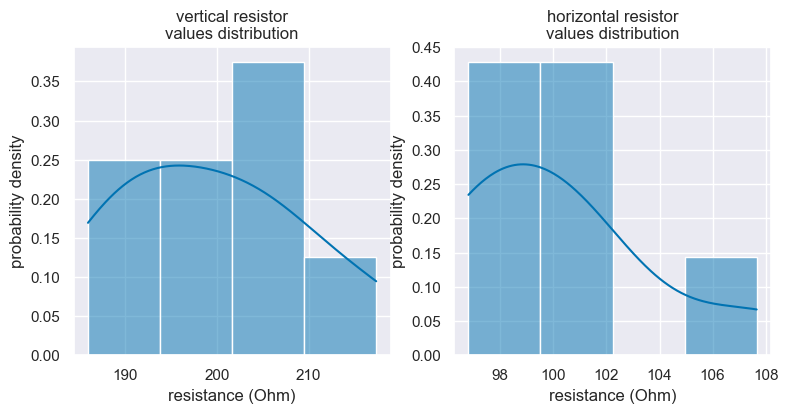

In [128]:
fig, ax = plt.subplots(1,2, figsize=(9,4))
sns.histplot(Rv, ax=ax[0], stat="probability", kde=True)
ax[0].set_xlabel('resistance (Ohm)')
ax[0].set_ylabel('probability density')
ax[0].grid(True)
ax[0].set_title('vertical resistor\nvalues distribution')
sns.histplot(Rh, ax=ax[1], stat="probability", kde=True)
ax[1].set_xlabel('resistance (Ohm)')
ax[1].set_ylabel('probability density')
ax[1].grid(True)
ax[1].set_title('horizontal resistor\nvalues distribution')

In [129]:
import pdb

nodeVolt = np.zeros(nbits)# node voltages, from lsb to msb
reqs = np.zeros(nbits)# equivalent resistances at each node, from lsb to msb
# setup the equivalent resistances
reqs[0] = Rg*Rv[0]/(Rg+Rv[0])
# define the vectorizable resistance function to 
# compute the equivalent resistance at each node

def reqf(node, Rv=None, Rh=None, Req=None):
    Req[node] = (Rh[node-1]+Req[node-1])*Rv[node] / (Rh[node-1] + Rv[node]+ Req[node-1])
reqfp = partial(reqf, Rv=Rv, Rh=Rh, Req=reqs)
# vectorize the function
reqvf = np.vectorize(reqfp)
reqvf(np.arange(1,nbits)) # compute the equivalent resistances at each node
# compute the node voltages 
nodeVolt[-1] = -vref
def vnf(node , nodeVolt=None, Req=None, Rh=None):
    nodeVolt[node] = nodeVolt[node+1]*Req[node] / (Req[node]+Rh[node])
vnfp = partial(vnf, nodeVolt=nodeVolt, Req=reqs, Rh=Rh)
vnvf = np.vectorize(vnfp)
vnvf(np.arange(nbits-1)[::-1]) # compute the node voltages at each node
nodeVolt = nodeVolt[::-1] # flip
# compute the equivalent currents at each vertical resistor in case the bit is ON
currents = nodeVolt / Rv

codes = np.arange(2**nbits)
incodes_bin = dec2bin(codes, nbits)
# compute the output currents for each input code 
current_out = np.array([np.sum(currents[incode == 1]) for incode in incodes_bin])
# compute the output voltage for each input code
vout = -current_out*Rf
reqs, nodeVolt, Rv

(array([100.87033051, 100.12460224,  97.20252177, 100.51788175,
         98.75949061,  99.88315421,  98.07138158, 104.12111209]),
 array([-1.        , -0.49072618, -0.23616932, -0.1187435 , -0.05934093,
        -0.02969326, -0.01485715, -0.00758145]),
 array([194.31043651, 202.8937136 , 189.018677  , 208.30611074,
        194.02588388, 203.22533167, 185.92976806, 217.37075596]))

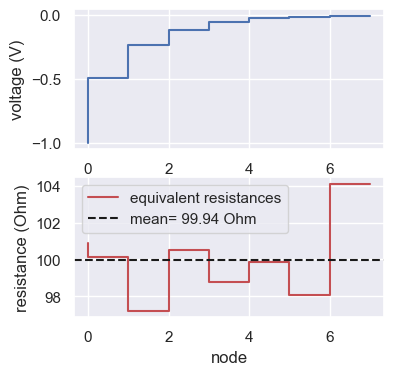

In [130]:
# observe the node voltages and equivalent resistances at each node
fig, ax = plt.subplots(2,1, figsize=(4,4))
ax[0].step(np.arange(nbits), nodeVolt, 'b', label='node voltages')
ax[0].set_xlabel('node')
ax[0].set_ylabel('voltage (V)')
ax[0].grid(True)
ax[1].step(np.arange(nbits), reqs, 'r', label='equivalent resistances')
ax[1].set_xlabel('node')
ax[1].set_ylabel('resistance (Ohm)')
ax[1].axhline(np.mean(reqs), color='k', linestyle='--', label='mean= {:.2f} Ohm'.format(np.mean(reqs)))
ax[1].legend()
ax[1].grid(True)

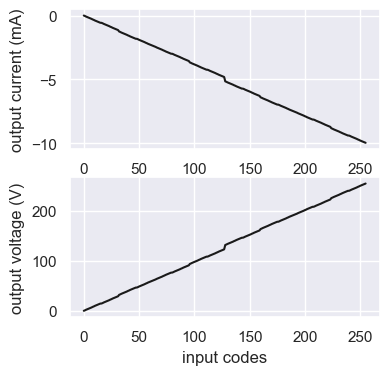

In [131]:
# observe both the input and output codes
fig, ax = plt.subplots(2,1, figsize=(4,4))
ax[0].plot(codes, current_out/1e-3, c='k')
ax[0].set_xlabel('input codes')
ax[0].set_ylabel('output current (mA)')
ax[0].grid(True)
ax[1].plot(codes, vout, c='k')
ax[1].set_xlabel('input codes')
ax[1].set_ylabel('output voltage (V)')
ax[1].grid(True)

In [132]:
# compute the DNL and INL, and the effective number of bits of the DAC
vlsb_measured = (vout[-1] - vout[0])/(2**nbits-1)
dnl = np.diff(vout)/vlsb_measured - 1
inl = np.array([0] + np.cumsum(dnl).tolist())
assert np.allclose(inl[-1], 0) # check if the INL is zero in its first and last index
assert np.allclose(inl[0], 0) # check if the DNL is zero in its last index
assert len(dnl) == 2**nbits-1
assert len(inl) == 2**nbits
# compute the effective number of bits of the DAC
dac_linearity = nbits - np.log2(np.max(inl) - np.min(inl))
dac_linearity

5.021604552845352

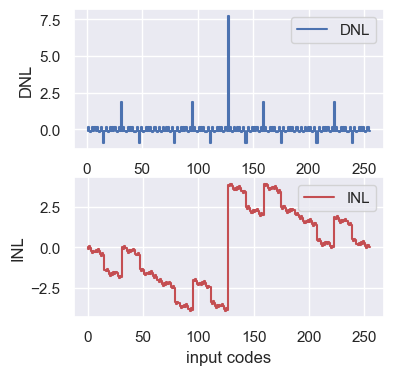

In [133]:
# plot the DNL and INL
fig, ax = plt.subplots(2,1, figsize=(4,4))
ax[0].step(codes[1:], dnl, 'b', label='DNL')
ax[0].set_xlabel('input codes')
ax[0].set_ylabel('DNL')
ax[0].legend()
ax[0].grid(True)
ax[1].step(codes, inl, 'r', label='INL')
ax[1].set_xlabel('input codes')
ax[1].set_ylabel('INL')
ax[1].legend()
ax[1].grid(True)

In [134]:
# generate several binary weighted resistor
# circuits, with random resistance wheights 
# every time, and observe the histogram of 
# the resolution of the DAC
ncircuits = 100
dac_res = [] # measure the effective resolution for each of the circuits
# resistance mismatch in ohm, following a normal distribution
ru = 2e3 # unit resistance in ohm
u_err = 0.0
u_std = 0.05 # 15% of the unit resistance for a semiconductor resistor
codes = np.arange(2**nbits)
# get the binary codes
incodes_bin = dec2bin(codes, nbits)

for circ in range(ncircuits):
    # model the resistors
    ru = 100 # ohm - unit resistance
    # vertical resistors = 2*Ru
    rv = 2*ru*np.ones(nbits+1)
    # horizontal resistors = Ru
    rh = ru*np.ones(nbits-1)
    # resistance mismatch in ohm, following a normal distribution
    u_err = 0.0
    sigma = 10 # consider : 1 sigma, 2 sigma or 3 sigma (wrost case scenario)
    u_std = 0.15 # 15% of the unit resistance for a semiconductor resistor
    r_err = normal(u_err, u_std, nbits+1)
    Rv = rv + rv*r_err
    Rg = Rv[-1]
    Rv = Rv[:-1]
    r_err = normal(u_err, u_std, nbits-1)
    Rh = rh + rh*r_err
    # feedback resistor 
    Rf = ru*2**nbits
    
    nodeVolt = np.zeros(nbits)# node voltages, from lsb to msb
    reqs = np.zeros(nbits)# equivalent resistances at each node, from lsb to msb
    # setup the equivalent resistances
    reqs[0] = Rg*Rv[0]/(Rg+Rv[0])
    # define the vectorizable resistance function to 
    # compute the equivalent resistance at each node
    reqfp = partial(reqf, Rv=Rv, Rh=Rh, Req=reqs)
    # vectorize the function
    reqvf = np.vectorize(reqfp)
    reqvf(np.arange(1,nbits)) # compute the equivalent resistances at each node
    # compute the node voltages 
    nodeVolt[-1] = -vref
    
    vnfp = partial(vnf, nodeVolt=nodeVolt, Req=reqs, Rh=Rh)
    vnvf = np.vectorize(vnfp)
    vnvf(np.arange(nbits-1)[::-1]) # compute the node voltages at each node
    nodeVolt = nodeVolt[::-1] # flip
    # compute the equivalent currents at each vertical resistor in case the bit is ON
    currents = nodeVolt / Rv

    codes = np.arange(2**nbits)
    incodes_bin = dec2bin(codes, nbits)
    # compute the output currents for each input code 
    current_out = np.array([np.sum(currents[incode == 1]) for incode in incodes_bin])
    # compute the output voltage for each input code
    vout = -current_out*Rf
    
    # compute the DNL and INL, and the effective number of bits of the DAC
    vlsb_measured = (vout[-1] - vout[0])/(2**nbits-1)
    dnl = np.diff(vout)/vlsb_measured - 1
    inl = np.array([0] + np.cumsum(dnl).tolist())
    # compute the effective number of bits of the DAC
    dac_linearity = nbits - np.log2(np.max(inl) - np.min(inl))
    dac_res.append(dac_linearity)

Text(0.5, 1.0, 'DAC resolution distribution against resistor mismatch')

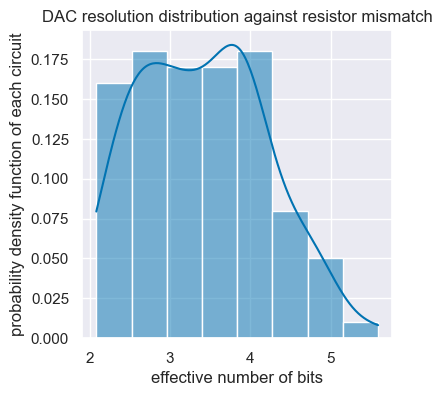

In [135]:
fig, ax = plt.subplots(1,1, figsize=(4,4))
sns.histplot(dac_res, ax=ax, stat="probability", kde=True)
ax.set_xlabel('effective number of bits')
ax.set_ylabel('probability density function of each circuit')
ax.grid(True)
ax.set_title('DAC resolution distribution against resistor mismatch')

<p align="justify">
From the above histogram it is possible to observe that although the R-2R DAC uses much less hardware, drastically reducing the number of resistors to 2N + 1, it is much more sensitive to resistor mismatch than the binary weighted resistor DAC. The decreasing voltage at each successive node of the R-2R array is successively more sensitive to resistor mismatch, as the mismatch at higher voltage nodes is much more critical than the mismatch at lower voltage nodes.
</p>